## Using **Decision tree Regressor** and **Support Vector Regressor** for forecasting on the stock data

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

data = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
aapl = data[['Close']].dropna()
aapl['Close_lag1']=aapl['Close'].shift(1)
aapl.dropna(inplace=True)
aapl.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,Close_lag1
Ticker,AAPL,
Date,,
2015-01-05,23.604338,24.288582
2015-01-06,23.606556,23.604338
2015-01-07,23.937567,23.606556
2015-01-08,24.857304,23.937567
2015-01-09,24.883974,24.857304


### Plotting ACF and PACF plots

<Figure size 1000x400 with 0 Axes>

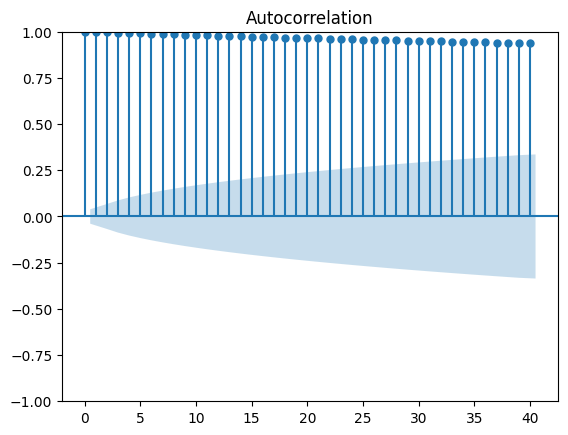

<Figure size 1000x400 with 0 Axes>

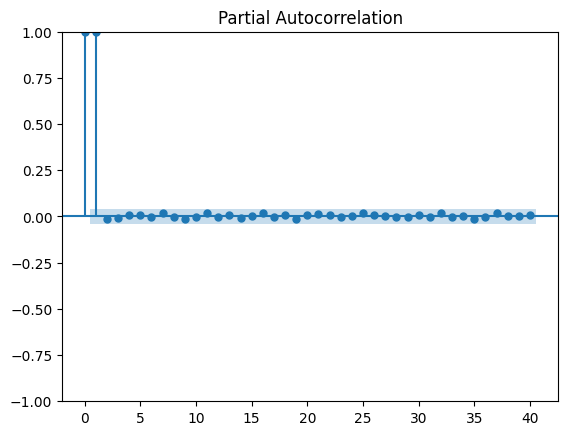

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
close_prices = data['Close']

plt.figure(figsize=(10, 4))
plot_acf(close_prices, lags=40)
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(close_prices, lags=40)
plt.show()

##### As seen in PACF plot we have to take lag of only 1 spike.

#### Fearture designing

In [3]:
X=aapl[['Close_lag1']]
y=aapl['Close']

### Data splitting into Training and Testing

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False) #Regular splits
train_size = int(len(aapl['Close']) * 0.7)

train = aapl['Close'].iloc[:train_size]
test = aapl['Close'].iloc[train_size:]
tscv = TimeSeriesSplit(n_splits=7) #Day chaining forward


### Decision Tree Regressor Forecasting with regular splits

MSE: 544.62
R2 Score: 0.37


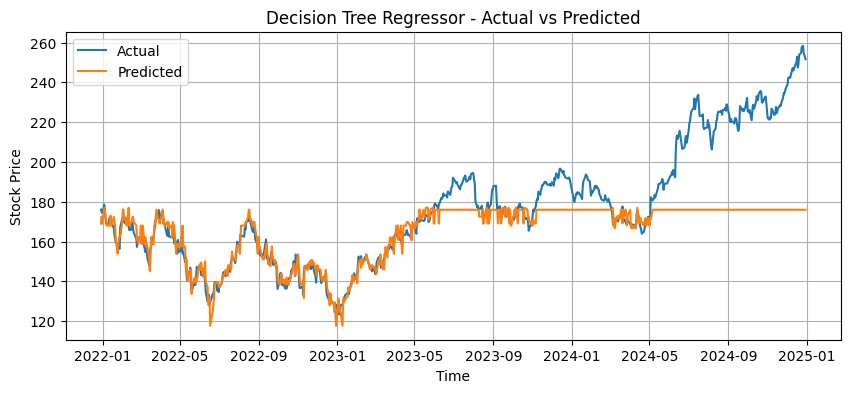

In [5]:
model_dec1=DecisionTreeRegressor(random_state=1)


model_dec1.fit(X_train, y_train)
y_pred_dec1 = model_dec1.predict(X_test)

mse_dec1 = mean_squared_error(y_test, y_pred_dec1)
r2_dec1 = r2_score(y_test, y_pred_dec1)



print(f"MSE: {mse_dec1:.2f}")
print(f"R2 Score: {r2_dec1:.2f}")

# Plot predictions
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual')
plt.plot(test.index,y_pred_dec1, label='Predicted')
plt.title('Decision Tree Regressor - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()




#### This model will only intrapolate, these models will not be able to predict the values out of range therefore will give flat-line when the data is out of range.

### Training SVR and testing it on time series splits

Fold MSE: 4.60, R2: 0.78
Fold MSE: 11.69, R2: 0.53
Fold MSE: 0.86, R2: 0.99
Fold MSE: 9.28, R2: 0.98
Fold MSE: 8.00, R2: 0.97
Fold MSE: 7.44, R2: 0.98
Fold MSE: 10.15, R2: 0.98


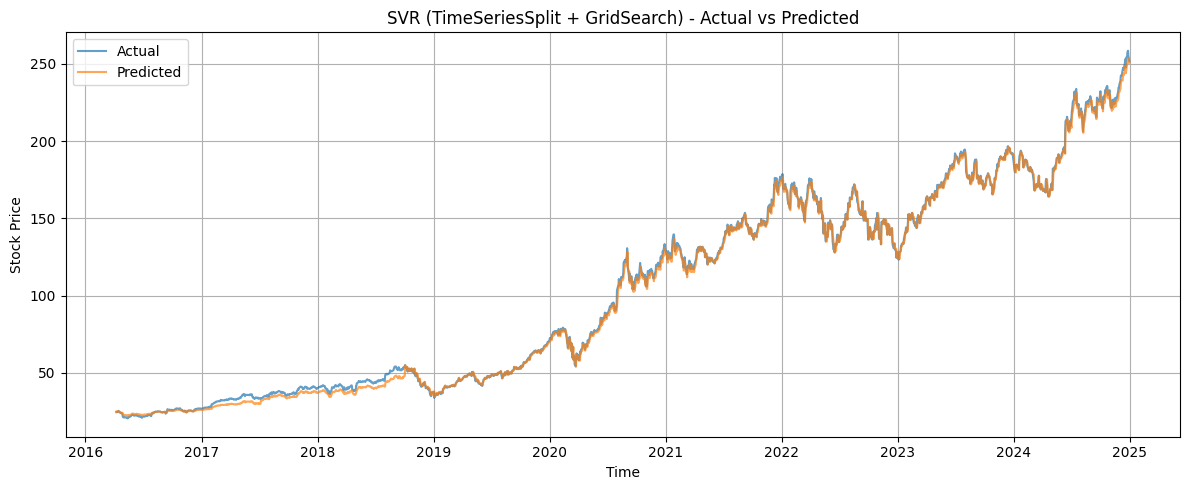

In [6]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

# Step 2: Scale features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Step 3: TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=7)

# Step 4: SVR + GridSearch
param_grid = {
    'C': [1, 10, 100],
    'gamma': [0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 0.2]
}

all_preds = []
all_actuals = []
all_dates = []

for train_idx, test_idx in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]
    dates_test = aapl.iloc[test_idx].index

    grid = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=3,
                        scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred_scaled = best_model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

    all_preds.extend(y_pred)
    all_actuals.extend(y_test_actual)
    all_dates.extend(dates_test)

    mse = mean_squared_error(y_test_actual, y_pred)
    r2 = r2_score(y_test_actual, y_pred)
    print(f"Fold MSE: {mse:.2f}, R2: {r2:.2f}")

# Step 5: Final plot
plt.figure(figsize=(12, 5))
plt.plot(all_dates, all_actuals, label='Actual', alpha=0.7)
plt.plot(all_dates, all_preds, label='Predicted', alpha=0.7)
plt.title('SVR (TimeSeriesSplit + GridSearch) - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Results looked like overfitting as using lag = 1, time series splits(data forward chaining) causing data leakage.

### Improving the model with 30 lag values and scaling down the graph to 5 so that we can notice the values that are off

In [7]:
aapl=yf.download('AAPL', start='2015-01-01', end='2024-12-31')
aapl=aapl[['Close']]
max_lag = 30
for lag in range(1, max_lag + 1):
    aapl[f'Close_lag{lag}'] = aapl['Close'].shift(lag)

# Now drop all rows with NaNs once after all shifts
aapl.dropna(inplace=True)

aapl.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,Close_lag1,Close_lag2,Close_lag3,Close_lag4,Close_lag5,Close_lag6,Close_lag7,Close_lag8,Close_lag9,...,Close_lag21,Close_lag22,Close_lag23,Close_lag24,Close_lag25,Close_lag26,Close_lag27,Close_lag28,Close_lag29,Close_lag30
Ticker,AAPL,,,,,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-17,28.510586,28.343317,28.205034,27.852640,27.214754,26.701771,26.525576,26.750847,26.561256,26.359102,...,23.730965,24.392996,24.486303,24.270815,24.883974,24.857304,23.937567,23.606556,23.604338,24.288582
2015-02-18,28.709093,28.510586,28.343317,28.205034,27.852640,27.214754,26.701771,26.525576,26.750847,26.561256,...,23.546570,23.730965,24.392996,24.486303,24.270815,24.883974,24.857304,23.937567,23.606556,23.604338
2015-02-19,28.648870,28.709093,28.510586,28.343317,28.205034,27.852640,27.214754,26.701771,26.525576,26.750847,...,24.153065,23.546570,23.730965,24.392996,24.486303,24.270815,24.883974,24.857304,23.937567,23.606556
2015-02-20,28.883055,28.648870,28.709093,28.510586,28.343317,28.205034,27.852640,27.214754,26.701771,26.525576,...,24.337458,24.153065,23.546570,23.730965,24.392996,24.486303,24.270815,24.883974,24.857304,23.937567
2015-02-23,29.663685,28.883055,28.648870,28.709093,28.510586,28.343317,28.205034,27.852640,27.214754,26.701771,...,24.970606,24.337458,24.153065,23.546570,23.730965,24.392996,24.486303,24.270815,24.883974,24.857304


Fold MSE: 0.30, R2: 0.99
Fold MSE: 0.95, R2: 0.97
Fold MSE: 0.84, R2: 0.99
Fold MSE: 7.61, R2: 0.99
Fold MSE: 13.09, R2: 0.94
Fold MSE: 7.87, R2: 0.97
Fold MSE: 9.68, R2: 0.98
Average Mean Squared error 5.763779900228839
Average R2 error 0.9758763167496299


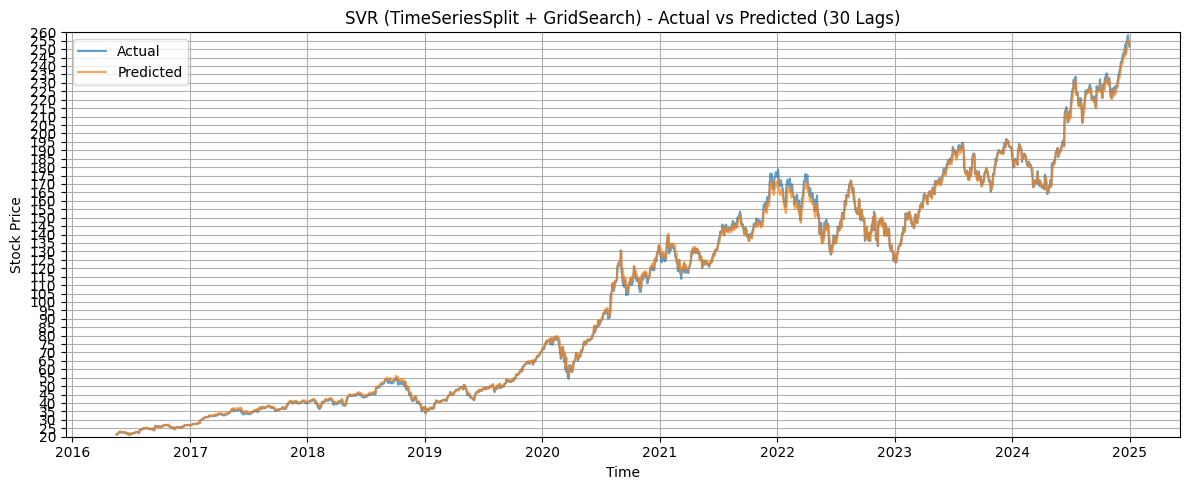

In [14]:
import matplotlib.ticker as ticker

# Prepare feature set (X) and target (y)
max_lag=29
X = aapl[[f'Close_lag{i}' for i in range(1, max_lag+1)]]
y = aapl['Close']

# Step 3: Scale the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Step 4: TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=7)

# Step 5: Define hyperparameters for SVR
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'epsilon': [0.001, 0.01, 0.1, 0.2]
}
avg_mse=0
avg_r2=0

# Step 6: Train, Tune, and Predict in each split
all_preds = []
all_actuals = []
all_dates = []

for train_idx, test_idx in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]
    dates_test = aapl.iloc[test_idx].index

    # GridSearch for best SVR model
    grid = GridSearchCV(
        SVR(kernel='rbf'),
        param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    # Predict and inverse scale
    y_pred_scaled = best_model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

    # Collect for plotting
    all_preds.extend(y_pred)
    all_actuals.extend(y_test_actual)
    all_dates.extend(dates_test)

    # Fold metrics
    mse = mean_squared_error(y_test_actual, y_pred)
    avg_mse+=mse
    r2 = r2_score(y_test_actual, y_pred)
    avg_r2+=r2
    print(f"Fold MSE: {mse:.2f}, R2: {r2:.2f}")
print("Average Mean Squared error",avg_mse/7)
print("Average R2 error", avg_r2/7)
# Step 7: Final Plot
plt.figure(figsize=(12, 5))
plt.plot(all_dates, all_actuals, label='Actual', alpha=0.7)
plt.plot(all_dates, all_preds, label='Predicted', alpha=0.7)
plt.title('SVR (TimeSeriesSplit + GridSearch) - Actual vs Predicted (30 Lags)')
plt.xlabel('Time')
plt.ylabel('Stock Price')

# Set y-axis ticks to intervals of 5
ax = plt.gca()  # get current axis
y_min = int(min(min(all_actuals), min(all_preds)) // 5) * 5
y_max = int(max(max(all_actuals), max(all_preds)) // 5 + 1) * 5
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
plt.ylim(y_min, y_max)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Do it on regular splits to avoid data leakage but then learnt about the problem of lags which is leading to prediction of the stock prices on the basis of last value means the lag value

Best Params: {'C': 10, 'epsilon': 0.001, 'gamma': 0.01}
Test MSE: 6.73, R2: 0.99


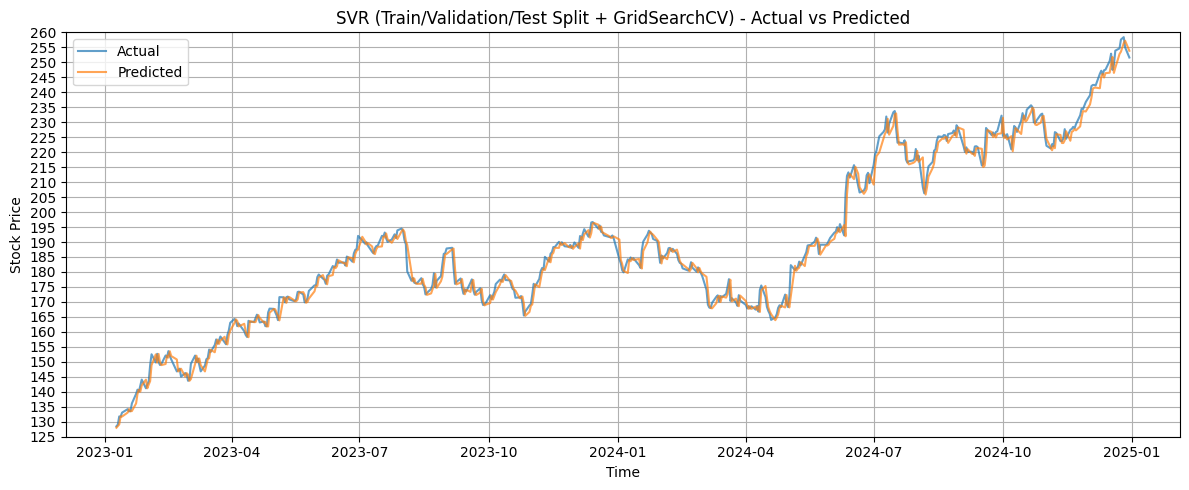

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Step 1: Prepare lagged features
max_lag = 1
X = aapl[[f'Close_lag{i}' for i in range(1, max_lag + 1)]].values
y = aapl['Close'].values.reshape(-1, 1)

# Step 2: Scale
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y).ravel()

# Step 3: Chronological Train (60%) + Val (20%) + Test (20%) split
total_len = len(X_scaled)
train_size = int(0.6 * total_len)
val_size = int(0.2 * total_len)

X_trainval, X_test = X_scaled[:train_size+val_size], X_scaled[train_size+val_size:]
y_trainval, y_test = y_scaled[:train_size+val_size], y_scaled[train_size+val_size:]
dates_trainval, dates_test = aapl.index[:train_size+val_size], aapl.index[train_size+val_size:]

# Define PredefinedSplit for GridSearchCV
val_fold = [-1]*train_size + [0]*val_size  # -1 for training, 0 for validation
ps = PredefinedSplit(test_fold=val_fold)

# Step 4: GridSearch on train+val
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'epsilon': [0.001, 0.01, 0.1, 0.2]
}

grid = GridSearchCV(
    SVR(kernel='rbf'),
    param_grid,
    scoring='neg_mean_squared_error',
    cv=ps,
    n_jobs=-1
)
grid.fit(X_trainval, y_trainval)
best_model = grid.best_estimator_

print(f"Best Params: {grid.best_params_}")

# Step 5: Final evaluation on the 20% test set
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

mse = mean_squared_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"Test MSE: {mse:.2f}, R2: {r2:.2f}")

# Step 6: Plotting
plt.figure(figsize=(12, 5))
plt.plot(dates_test, y_test_actual, label='Actual', alpha=0.7)
plt.plot(dates_test, y_pred, label='Predicted', alpha=0.7)
plt.title('SVR (Train/Validation/Test Split + GridSearchCV) - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')

# Y-axis ticks
ax = plt.gca()
y_min = int(min(min(y_test_actual), min(y_pred)) // 5) * 5
y_max = int(max(max(y_test_actual), max(y_pred)) // 5 + 1) * 5
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
plt.ylim(y_min, y_max)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **Key Learning**: after this was that time series data almost always overfits as when we are predicting in this if we are training 700 values and predicting 701 it will predict something close to 700th value, if we are predicting 702 it will use 701 value which can lead to leakage and then it overfits, and as timeseries data always requires lag in every case

In [16]:
# lags = 5,10,15,20
# graph = ko scale down karo
# search about folds,svr


# do it on regular time series splits,
# teain, validation and test splits and then
# see how to train and validate being used and then


# Key Learning after this was that time series data almost always overfits as when we are predicting in this if we are training 700 values and predicting 701 it will predict something close to 700th value, if we are predicting 702 it will use 701 value which can lead to leakage and then it overfits, and as timeseries data always requires lag in every case


# multi step ahead
# lstm

